Decision Tree Visualization: 

|--- Outlook == Rainy
    |--- Humidity == Normal
         -> Predict: Yes
    |--- Humidity == High
        |--- Temperature == Mild
             -> Predict: No
        |--- Temperature == Hot
            |--- Windy == True
                 -> Predict: No
            |--- Windy == False
                 -> Predict: Yes
|--- Outlook == Overcast
     -> Predict: Yes
|--- Outlook == Sunny
    |--- Windy == True
         -> Predict: No
    |--- Windy == False
         -> Predict: Yes




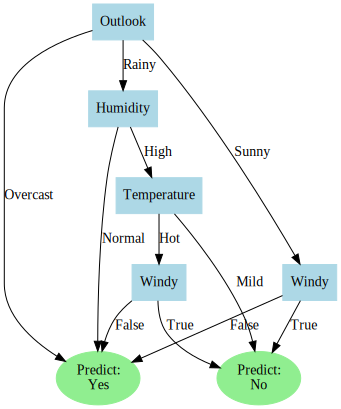

In [6]:
import math
from collections import Counter
from graphviz import Digraph

def entropy(labels):
    counts = Counter(labels)
    total = len(labels)
    ent = 0.0
    for count in counts.values():
        p = count / total
        ent -= p * math.log2(p)
    return ent

def information_gain(data, labels, attribute_index):
    base_entropy = entropy(labels)
    total = len(labels)

    subsets = {}
    for row, label in zip(data, labels):
        value = row[attribute_index]
        subsets.setdefault(value, []).append(label)

    weighted_entropy = 0.0
    for subset_labels in subsets.values():
        weighted_entropy += (len(subset_labels) / total) * entropy(subset_labels)

    return base_entropy - weighted_entropy

def majority_label(labels):
    return Counter(labels).most_common(1)[0][0]

def id3(data, labels, attributes):
    if len(set(labels)) == 1:
        return labels[0]
    if not attributes:
        return majority_label(labels)

    gains = [information_gain(data, labels, attr) for attr in attributes]
    best_attr = attributes[gains.index(max(gains))]

    tree = {best_attr: {}}
    values = set(row[best_attr] for row in data)

    for value in values:
        sub_data = []
        sub_labels = []
        for row, label in zip(data, labels):
            if row[best_attr] == value:
                sub_data.append(row)
                sub_labels.append(label)

        remaining_attrs = [a for a in attributes if a != best_attr]

        if not sub_data:
            tree[best_attr][value] = majority_label(labels)
        else:
            tree[best_attr][value] = id3(sub_data, sub_labels, remaining_attrs)

    return tree

def visualize_tree_graph(tree, feature_names, parent_name=None, graph=None, edge_label=""):
    if graph is None:
        graph = Digraph(format='png')
        graph.attr('node', shape='box', style='filled', color='lightblue')

    # Create a unique ID for the current node
    node_id = str(id(tree))

    if not isinstance(tree, dict):
        # Leaf Node (Prediction)
        graph.node(node_id, label=f"Predict:\n{tree}", color='lightgreen', shape='ellipse')
        if parent_name:
            graph.edge(parent_name, node_id, label=edge_label)
        return graph

    # Decision Node
    attr_index = next(iter(tree))
    attr_name = feature_names[attr_index]

    graph.node(node_id, label=attr_name)

    if parent_name:
        graph.edge(parent_name, node_id, label=edge_label)

    # Recurse for branches
    for value, subtree in tree[attr_index].items():
        visualize_tree_graph(subtree, feature_names, parent_name=node_id, graph=graph, edge_label=str(value))

    return graph

def print_tree_pretty(tree, feature_names, indent=""):
    # Base case: If the node is a leaf (label), just print it
    if not isinstance(tree, dict):
        print(f"{indent} -> Predict: {tree}")
        return

    # Recursive step: Extract the attribute index and branches
    # The tree dictionary structure is { attribute_index: { value: subtree } }
    attribute_index = next(iter(tree))
    attribute_name = feature_names[attribute_index]

    # Get the dictionary of values for this attribute
    branches = tree[attribute_index]

    for value, subtree in branches.items():
        print(f"{indent}|--- {attribute_name} == {value}")
        print_tree_pretty(subtree, feature_names, indent + "    ")


# Columns: Outlook, Temperature, Humidity, Windy
X_custom = [
    ['Rainy', 'Hot', 'High', 'False'],      # 0
    ['Rainy', 'Hot', 'High', 'True'],       # 1
    ['Overcast', 'Hot', 'High', 'False'],   # 2
    ['Sunny', 'Mild', 'High', 'False'],     # 3
    ['Sunny', 'Cool', 'Normal', 'False'],   # 4
    ['Sunny', 'Cool', 'Normal', 'True'],    # 5
    ['Overcast', 'Cool', 'Normal', 'True'], # 6
    ['Rainy', 'Mild', 'High', 'False'],     # 7
    ['Rainy', 'Cool', 'Normal', 'False'],   # 8
    ['Sunny', 'Mild', 'Normal', 'False'],   # 9
    ['Rainy', 'Mild', 'Normal', 'True'],    # 10
    ['Overcast', 'Mild', 'High', 'True'],   # 11
    ['Overcast', 'Hot', 'Normal', 'False'], # 12
    ['Sunny', 'Mild', 'High', 'True']       # 13
]

# Label: Play Golf
y_custom = [
    'Yes', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes',
    'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No'
]

# Build & Print Tree
attributes = list(range(len(X_custom[0])))
feature_names = ["Outlook", "Temperature", "Humidity", "Windy"]

my_tree = id3(X_custom, y_custom, attributes)

print("Decision Tree Visualization: \n")
print_tree_pretty(my_tree, feature_names)
print("\n")
graph = visualize_tree_graph(my_tree, feature_names)
graph